Importing necessary libraries

In [2]:
import gizmo_analysis as gizmo
import utilities as ut
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from scipy import optimize

Setting text properties for plots

In [3]:
plt.rcParams.update({'font.size': 16.5})
plt.ticklabel_format(axis='both', style='sci', scilimits=(0,0))
plt.close()

Constructing numerical PDF

Let $V$ be the set of values and $W$ be the set of corresponding weights, each having a size $n$. Further, let a scalar $\eta$ be called the norm. The normalization of the constructed PDF $g(z)$ is then -

$$\int_{-\infty}^{\infty} g(z) dz = \frac{1}{\eta} \sum_{i = 1}^{n} w_i$$

In [4]:
def num_PDF(values, weights, left, right, bin_size, norm):
    
    bins = np.arange(left, right, bin_size)
    heights, edges = np.histogram(values, bins, weights = weights)
    centers = 0.5*(edges[1:] + edges[:-1])
    heights = heights/(bin_size*norm)

    return centers, heights

Fitting function, Gaussian - 

$$ p(z)= \frac{A}{\sqrt{2 \pi \sigma^2}} e^{-\frac{(z-\mu)^2}{2 \sigma^2}}$$

Which we want to obey the same normalization as the numerical PDF -

$$ \int_{-\infty}^{\infty} p(z) dz = \frac{1}{\eta} \sum_{i = 1}^{n} w_i$$

In [5]:
def fit_func(Z, A, mu, sigma):
    
    P = (A/np.sqrt(2*np.pi*sigma**2))*np.exp(-((Z-mu)**2/(2*sigma**2)))
    
    return P 

Constructing fitted PDF

In [6]:
def fit_PDF(centers, heights):

    fit = np.zeros(len(centers))
    fit_params = np.zeros(3)

    # If all bins are empty
    if (np.all(heights == 0)):
        fit_params = np.array([0, float('nan'), float('inf')])
    
    # Otherwise
    else:

        # Wisely guessing fit parameters to ease the fitting routine's job
        
        # Information about the peak in the numerical PDF
        peak_ind = np.where(heights == np.max(heights))[0][0]
        peak_height = np.max(heights)
        
        # mu is where the numerical PDF peaks
        mu = centers[peak_ind]
        
        # Estimating sigma using FWHM
        sigma = 0
        
        for i in range(0, peak_ind):
            if(heights[i] >= peak_height/2):
                sigma = (mu - centers[i])/np.sqrt(2*np.log(2))
                break
          
        # Estimating A accordingly, by using the peak value at mu
        A = np.sqrt(2*np.pi*sigma**2)*peak_height
        
        # Fitting the data using scipy.optimize.curve_fit()
            
        guess_params = np.array([A, mu, sigma])
        fit_params, fit_covar = optimize.curve_fit(fit_func, centers, heights, p0=guess_params)
        fit = fit_func(centers, *fit_params)
    
    return fit, fit_params

Importing dataset

In [7]:
# Specifying simulation directory and the directory to save results in
wdir = str(input('Enter simulation directory path: '))
sdir = wdir + str(input('Enter path of storage directory relative to simulation directory: '))

# Specifying snapshot index
sim_index = int(input('Enter snapshot index: '))

# Importing data from the snapshot
part = gizmo.io.Read.read_snapshots(['star', 'gas', 'dark'], 'index', sim_index, assign_hosts_rotation = True, 
                                    simulation_directory = wdir)

# Getting halo properties
halo_properties = ut.particle.get_halo_properties(part, 'all')

Enter simulation directory path: /Users/thepoetoftwilight/Documents/CASSI2020/CASSI2020-Data/m10q_res16000_test/
Enter path of storage directory relative to simulation directory: files/gauss/
Enter snapshot index: 600

# in utilities.simulation.Snapshot():
* reading:  Users/thepoetoftwilight/Documents/CASSI2020/CASSI2020-Data/m10q_res16000_test/snapshot_times.txt

  using snapshot index = 600, redshift = 0.000


# in gizmo_analysis.gizmo_io.Read():
* reading header from:  Users/thepoetoftwilight/Documents/CASSI2020/CASSI2020-Data/m10q_res16000_test/output/snapshot_600.hdf5
  snapshot contains the following number of particles:
    dark      (id = 1): 260408 particles
    dark2     (id = 2): 2281573 particles
    gas       (id = 0): 259203 particles
    star      (id = 4): 1205 particles
    blackhole (id = 5): 0 particles

* reading species: ['star', 'gas', 'dark']
* reading particles from:
    Users/thepoetoftwilight/Documents/CASSI2020/CASSI2020-Data/m10q_res16000_test/output/snapsho

In [8]:
# Creating the fit_info file

info = open(sdir + 'fit_info.txt', 'w')
info.write('Fit Information \n \n')
info.close()

Obtaining key properties of the galaxy

In [9]:
# Virial radius

r_vir = halo_properties['radius']

# Finding radial distance, temperature, number density, and mass of grid cells

radii = part['gas'].prop('host.distance.principal.spherical')[:,0]
temperatures = part['gas'].prop('temperature')
number_densities = part['gas'].prop('number.density')
masses = part['gas'].prop('mass')

Defining the ISM and its phases

In [10]:
# Create a dictionary linking phases to numbers

phases = {0: 'ISM', 1: 'HIM', 2: 'WIM', 3: 'WNM', 4: 'CNM'}
num_phases = len(phases)

In [11]:
# Defining the ISM and its phases

select_phases = []

# ISM
select_phases.append(radii < 0.1*r_vir)

# HIM
select_phases.append(np.all([(radii < 0.1*r_vir), (temperatures >= 10**5.5)], axis = 0))

# WIM
select_phases.append(np.all([(radii < 0.1*r_vir), (temperatures >= 10**4), (temperatures < 10**5.5)], axis = 0))

# WNM
select_phases.append(np.all([(radii < 0.1*r_vir), (temperatures >= 10**3), (temperatures < 10**4)], axis = 0))

# CNM
select_phases.append(np.all([(radii < 0.1*r_vir), (temperatures < 10**3)], axis = 0))

Choosing metals and pre-processing abundances

In [12]:
# Defining metals of interest

metals = ['c','n','o','ne','mg','si','s','ca','fe']

# Writing this list to fit_info.txt

info = open(sdir + 'fit_info.txt', 'a')

info.write('Elements \n \n')

info.write('[')
for i in range(0, len(metals)):
    if(i < len(metals)-1):
        info.write(metals[i] + ',')
    else:
        info.write(metals[i] + ']')
        
info.write('\n \n')

info.close()

In [13]:
# Finding the mass and abundance of metals in the ISM as well as its various phases by grid cells

# Grid distribution of masses by phase

mass_phases = []

for i in range(0, num_phases):
    mass_phases.append(masses[select_phases[i]])

# Grid distribution of abundances by phase

abundance_metals_phases = {}

for m in metals:
    abundance_metals_phases[m] = []
    for i in range(0, num_phases):
        abundance_metals_phases[m].append(part['gas'].prop('metallicity.' + m)[select_phases[i]])

Generating numerical PDF and its Gaussian fit

In [14]:
# Label and color arrays for later plots

labels_raw = ['ISM raw', 'HIM raw', 'WIM raw', 'WNM raw', 'CNM raw']
labels_fit = ['ISM fit', 'HIM fit', 'WIM fit', 'WNM fit', 'CNM fit']
colors = ['blue', 'orange', 'brown', 'green', 'black']

# Common bin-size for all numerical PDFs

bin_size = 0.05

Completed rendering numerical and fitted PDFs, writing fit parameters to fit_info.txt for C
Completed rendering numerical and fitted PDFs, writing fit parameters to fit_info.txt for N
Completed rendering numerical and fitted PDFs, writing fit parameters to fit_info.txt for O
Completed rendering numerical and fitted PDFs, writing fit parameters to fit_info.txt for Ne
Completed rendering numerical and fitted PDFs, writing fit parameters to fit_info.txt for Mg
Completed rendering numerical and fitted PDFs, writing fit parameters to fit_info.txt for Si
Completed rendering numerical and fitted PDFs, writing fit parameters to fit_info.txt for S
Completed rendering numerical and fitted PDFs, writing fit parameters to fit_info.txt for Ca
Completed rendering numerical and fitted PDFs, writing fit parameters to fit_info.txt for Fe


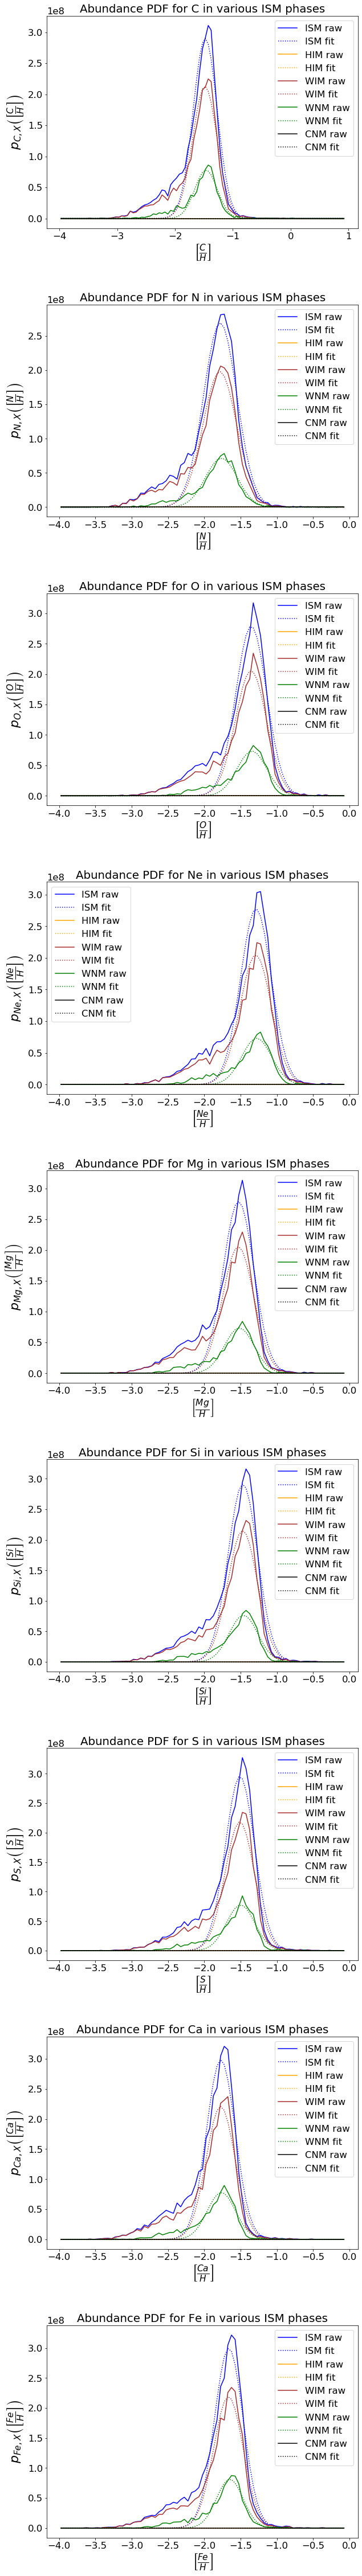

In [16]:
# Generating numerical PDFs and Gaussian fits, also writing fit parameters to fit_info.txt

info = open(sdir + 'fit_info.txt','a')

info.write('Info array is of the form [A, mu, sigma] \n \n')

mass_norm = np.sum(mass_phases[0])

fig, axes = plt.subplots(nrows = len(metals), ncols = 1, figsize = (10, 64))

for k in range(0, len(metals)):
    
    ax = axes[k]
    m = metals[k]
    
    info.write(m + '\n \n')

    # Creating bins

    left = np.floor(np.min(abundance_metals_phases[m][0]))
    right = np.ceil(np.max(abundance_metals_phases[m][0]))

    for i in range(0, len(phases)):
    
        # Compute the numerical PDF
        
        centers, heights = num_PDF(abundance_metals_phases[m][i], mass_phases[i], 
                                   left, right, bin_size, mass_norm)
        
        # Compute the fitted PDF
        
        fit, fit_params = fit_PDF(centers, heights)
        
        # Rescaling heights to achieve desired normalization
        
        heights *= mass_norm
        fit *= mass_norm
        fit_params[0] *= mass_norm
        
        # Plotting the raw data and the fit
       
        ax.plot(centers, heights, color = colors[i], label = labels_raw[i])
        ax.plot(centers, fit, color = colors[i], label = labels_fit[i], linestyle = ':')
        
        
        # Writing fit parameters into fit_info.txt
        
        info.write(phases[i] + ': [')
        
        for j in range(0, len(fit_params)):
            if(j < len(fit_params)-1):
                info.write(str(fit_params[j]) + ',')
            else:
                info.write(str(fit_params[j]) + ']')
        
        info.write('\n')

    # Labelling the plots
    
    ax.set_xlabel(r'$\left[ \frac{{{}}}{{H}} \right]$'.format(m.title()), fontsize = 22)
    ax.set_ylabel(r'$p_{{{0}, X}} \left( \left[ \frac{{{0}}}{{H}} \right] \right)$'.format(m.title()),
                 fontsize = 22)
    ax.set_title('Abundance PDF for {} in various ISM phases'.format(m.title()))
    ax.legend()
    
    # Saving the plots
    fig.tight_layout(pad = 3.0)
    extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(sdir + 'abundance_{}.png'.format(m.title()), bbox_inches=extent.expanded(1.35, 1.35))
    
    info.write('\n \n')
    
    print('Completed rendering numerical and fitted PDFs, writing fit parameters to fit_info.txt for {}'.format(m.title()))
    
info.close()